Human Activity Recognition: multiclass classification problem, with 6 actions to predict based on time series & statistical features.

(This is not an autoregressive time series prediction problem!)

Reference:
*   https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones
*   https://www.kaggle.com/erenaktas/human-activity-recognition
*   https://www.kaggle.com/code/sylvianclee/human-activity-recognition-cnn-lstm

### Load data

In [1]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -nq 'UCI HAR Dataset.zip'

--2022-10-03 09:27:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  86.4MB/s    in 0.7s    

2022-10-03 09:27:01 (86.4 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

folder = 'UCI HAR Dataset'
subfolder_t = 'Inertial Signals'

# We use dictionary variables to store train and test data
files_t = dict()
N = dict()  # number of samples
Df = 0      # number of features
Dt = 0      # number of time series
T = 0       # length of time series
K = 0       # number of categories
Y = dict()   # targets
y = dict()   # flattened targets
Xf = dict()  # features
Xt = dict()  # time series

# Import train and test data
for tag in ['train', 'test']:
  subfolder = os.path.join(folder, tag)
  # Load features and targets
  Y[tag] = (pd.read_csv(os.path.join(folder, tag,'y_'+tag+'.txt'), header=None).to_numpy() - 1)
  N[tag] = len(Y[tag])
  y[tag] = Y[tag].flatten()
  Xf[tag] = pd.read_csv(os.path.join(folder, tag,'X_'+tag+'.txt'), delim_whitespace=True, header=None).to_numpy()
  tmp, Df = Xf[tag].shape
  assert(tmp == N[tag])
  print(f'N[{tag}] = {N[tag]}')
  # Load time series: one input file per time series
  subfolder = os.path.join(subfolder, subfolder_t)
  files_t[tag] = sorted(os.listdir(subfolder))  # sort to ensure same order for train and test!
  Dt = len(files_t[tag])
  # Determine shape from input files
  tmp, T = pd.read_csv(os.path.join(subfolder, files_t[tag][0]), delim_whitespace=True, header=None).to_numpy().shape
  assert(tmp == N[tag])
  # Loop through input files
  Xt[tag] = np.zeros((N[tag], T, Dt))
  for d in range(Dt):
    Xt[tag][:,:,d] = pd.read_csv(os.path.join(subfolder, files_t[tag][d]), delim_whitespace=True, header=None).to_numpy()
print(f'Df = {Df}')
print(f'Dt = {Dt} (T = {T})')

# Create split version of Xt for multi-tail models
Xt_split = dict()
for tag in ['train', 'test']:
  Xt_split[tag] = [Xt[tag][:,:,d] for d in range(Dt)]

# Normalize Xf
Xf_scaled = dict()
scaler = StandardScaler()
Xf_scaled['train'] = scaler.fit_transform(Xf['train'])
Xf_scaled['test'] = scaler.transform(Xf['test'])

# Import labels
labels = pd.read_csv(os.path.join(folder, 'activity_labels.txt'), header=None, sep=' ')[1].to_dict()
K = len(labels)
print(f'K = {K} {labels}')

N[train] = 7352
N[test] = 2947
Df = 561
Dt = 9 (T = 128)
K = 6 {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'}


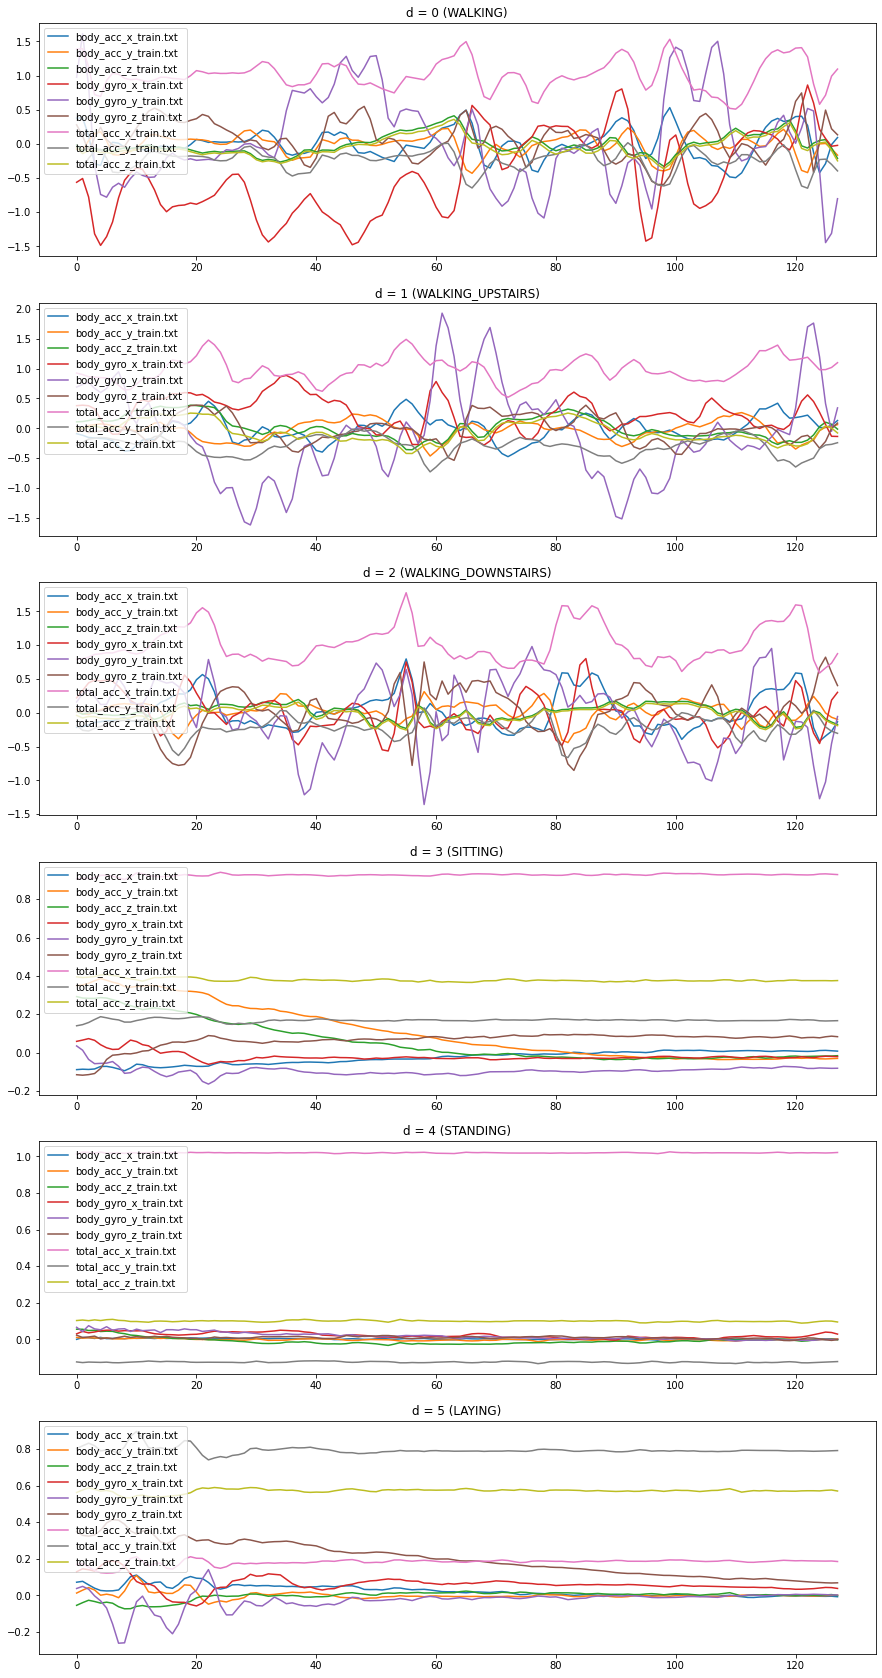

In [3]:
# Plot the D time series from one sample per category
fig, ax = plt.subplots(nrows=K, figsize=(15,30))
for d in range(K):
  lines = ax[d].plot(Xt['train'][np.where(y['train'] == d)[0][0],:,:]);
  ax[d].legend(lines, files_t['train'], loc='upper left')
  ax[d].set_title(f'd = {d} ({labels[d]})');

### LSTM on time series

In [5]:
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

i = Input(shape=(T,Dt))  # shape 128x9
x = LSTM(32, return_sequences=True)(i)  # shape 128x32
x = GlobalMaxPooling1D()(x)  # shape 32
x = Dense(K)(x)
model = Model(i, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           5376      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Create checkpoint to retrieve best model
checkpoint_path = 'har_lstm.h5'
checkpoint = ModelCheckpoint(
  filepath=checkpoint_path,
  monitor='val_accuracy',
  save_best_only=True,
  save_weights_only=True
)

# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
res = model.fit(
  Xt['train'], Y['train'],
  epochs=10,
  validation_data=(Xt['test'], Y['test']),
  callbacks=[checkpoint]
)

# Use best model
model.load_weights(checkpoint_path)

Epoch 1/10
230/230 [==============================] - 14s 53ms/step - loss: 1.1084 - accuracy: 0.6733 - val_loss: 0.7933 - val_accuracy: 0.7872
Epoch 2/10
230/230 [==============================] - 11s 49ms/step - loss: 0.4839 - accuracy: 0.8781 - val_loss: 0.4683 - val_accuracy: 0.8619
Epoch 3/10
230/230 [==============================] - 12s 50ms/step - loss: 0.2749 - accuracy: 0.9189 - val_loss: 0.3780 - val_accuracy: 0.8694
Epoch 4/10
230/230 [==============================] - 14s 62ms/step - loss: 0.2044 - accuracy: 0.9391 - val_loss: 0.3498 - val_accuracy: 0.8887
Epoch 5/10
230/230 [==============================] - 15s 67ms/step - loss: 0.1748 - accuracy: 0.9378 - val_loss: 0.3469 - val_accuracy: 0.8829
Epoch 6/10
230/230 [==============================] - 13s 58ms/step - loss: 0.1507 - accuracy: 0.9445 - val_loss: 0.2791 - val_accuracy: 0.8958
Epoch 7/10
230/230 [==============================] - 11s 49ms/step - loss: 0.1407 - accuracy: 0.9483 - val_loss: 0.2962 - val_accuracy:

train acc: 0.9574265505984766
test acc: 0.8975229046487954



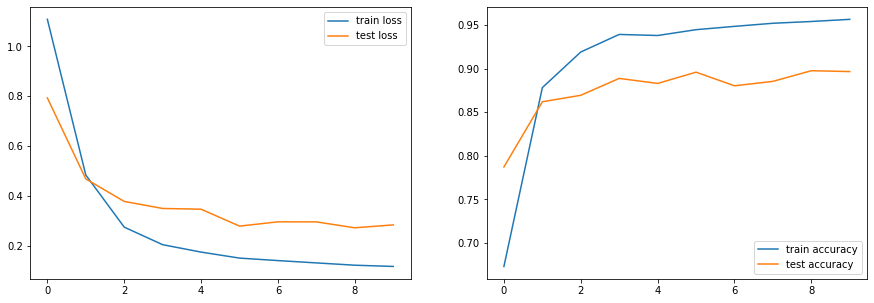

In [7]:
# Train & test accuracy
for tag in ['train', 'test']:
  print(f'{tag} acc: {np.mean(np.argmax(model.predict(Xt[tag]), axis=1) == y[tag])}')
print()

# Plot history
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(res.history['loss'], label='train loss')
ax[0].plot(res.history['val_loss'], label='test loss')
ax[0].legend();
ax[1].plot(res.history['accuracy'], label='train accuracy')
ax[1].plot(res.history['val_accuracy'], label='test accuracy')
ax[1].legend();

### LSTM on time series and features combined

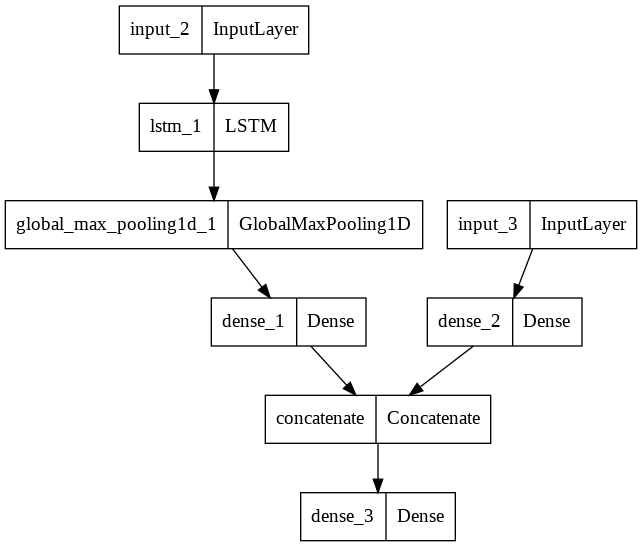

In [8]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

i = Input(shape=(T,Dt))  # shape 128x9
x = LSTM(32, return_sequences=True)(i)  # shape 128x32
x = GlobalMaxPooling1D()(x)  # shape 32
x = Dense(K)(x)

i2 = Input(shape=(Df,))  # shape 9
x2 = Dense(32, activation='relu')(i2)  # shape 32

x = Concatenate()([x, x2])
x = Dense(K)(x)
model_c = Model([i, i2], x)

plot_model(model_c)

In [10]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# Create checkpoint to retrieve best model
checkpoint_path_c = 'har_cnn_c.h5'
checkpoint_c = ModelCheckpoint(
  filepath=checkpoint_path_c,
  monitor='val_accuracy',
  save_best_only=True,
  save_weights_only=True
)

# Compile and fit
model_c.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
res_c = model_c.fit(
  [Xt['train'], Xf['train']], Y['train'],
  epochs=10,
  validation_data=([Xt['test'], Xf['test']], Y['test']),
  callbacks=[checkpoint_c]
)

# Use best model
model_c.load_weights(checkpoint_path_c)

Epoch 1/10
230/230 [==============================] - 17s 53ms/step - loss: 0.1668 - accuracy: 0.9406 - val_loss: 0.2043 - val_accuracy: 0.9284
Epoch 2/10
230/230 [==============================] - 12s 54ms/step - loss: 0.1032 - accuracy: 0.9634 - val_loss: 0.1636 - val_accuracy: 0.9393
Epoch 3/10
230/230 [==============================] - 12s 51ms/step - loss: 0.1154 - accuracy: 0.9603 - val_loss: 0.1940 - val_accuracy: 0.9213
Epoch 4/10
230/230 [==============================] - 11s 50ms/step - loss: 0.0880 - accuracy: 0.9663 - val_loss: 0.1517 - val_accuracy: 0.9376
Epoch 5/10
230/230 [==============================] - 12s 52ms/step - loss: 0.0779 - accuracy: 0.9691 - val_loss: 0.1341 - val_accuracy: 0.9467
Epoch 6/10
230/230 [==============================] - 12s 50ms/step - loss: 0.0633 - accuracy: 0.9773 - val_loss: 0.1563 - val_accuracy: 0.9389
Epoch 7/10
230/230 [==============================] - 12s 51ms/step - loss: 0.0770 - accuracy: 0.9744 - val_loss: 0.1443 - val_accuracy:

train acc: 0.9810935799782372
test acc: 0.9467254835425857



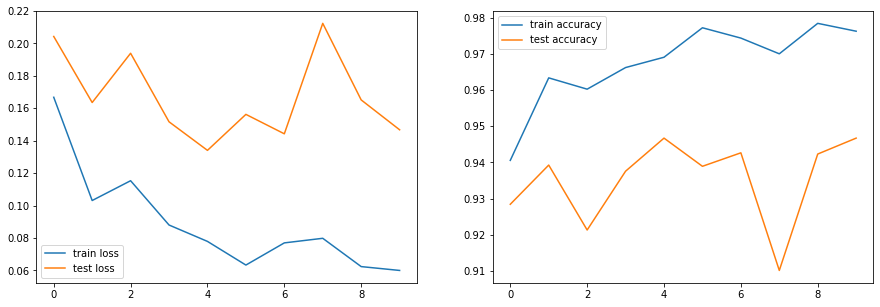

In [12]:
# Train & test accuracy
for tag in ['train', 'test']:
  print(f'{tag} acc: {np.mean(np.argmax(model_c.predict([Xt[tag], Xf[tag]]), axis=1) == y[tag])}')
print()

# Plot history
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(res_c.history['loss'], label='train loss')
ax[0].plot(res_c.history['val_loss'], label='test loss')
ax[0].legend();
ax[1].plot(res_c.history['accuracy'], label='train accuracy')
ax[1].plot(res_c.history['val_accuracy'], label='test accuracy')
ax[1].legend();